## From GARCH to multivariate GARCH and DCC

Remember that, for univariate Normal GARCH, we have the following formulas:

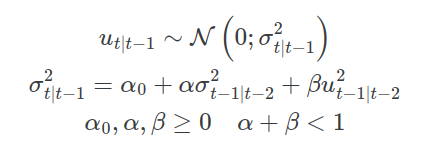

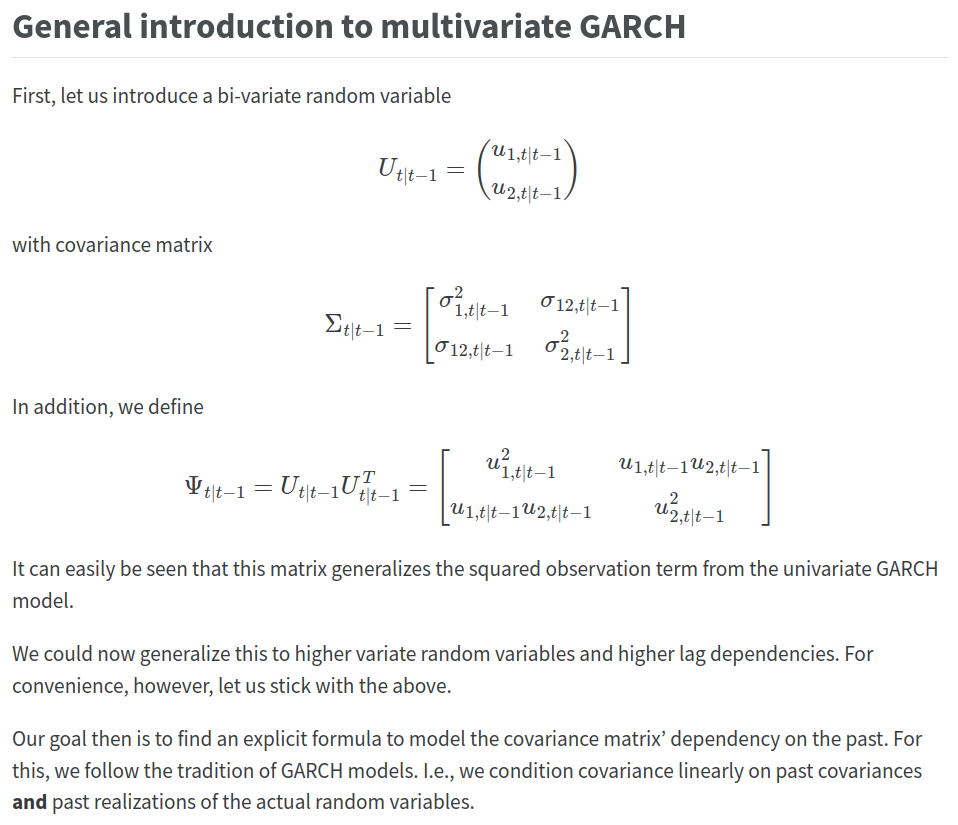

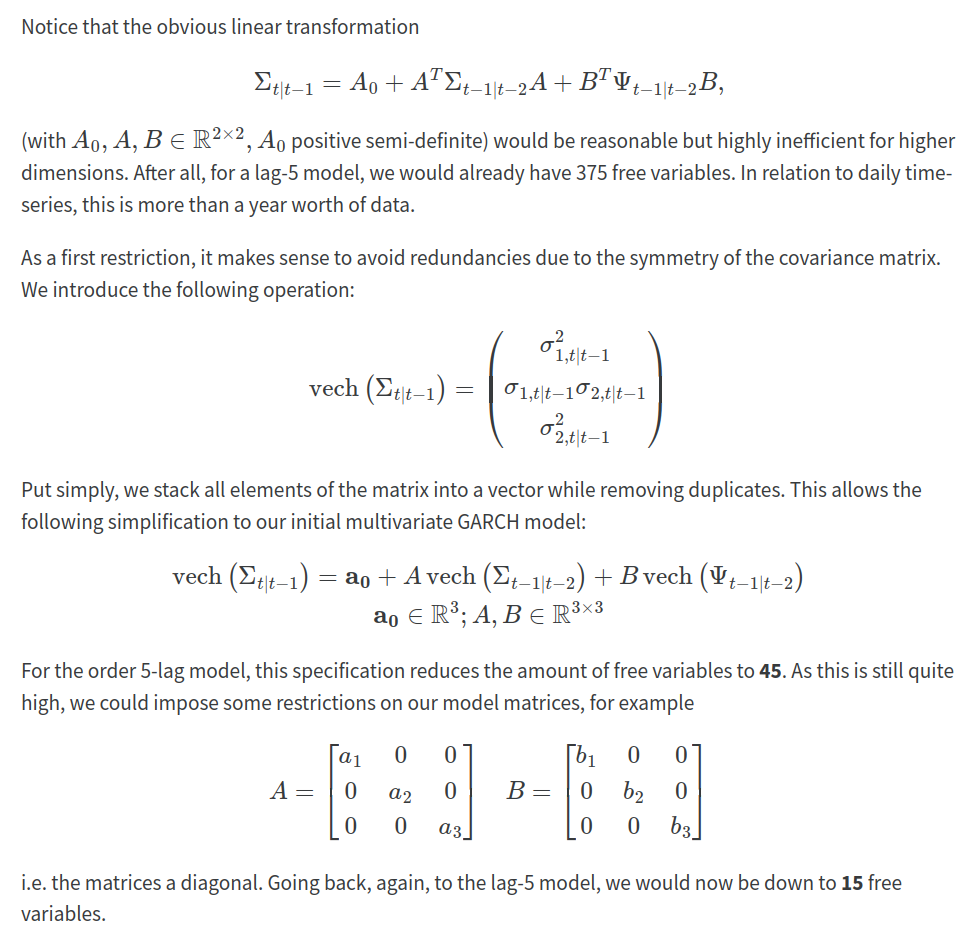

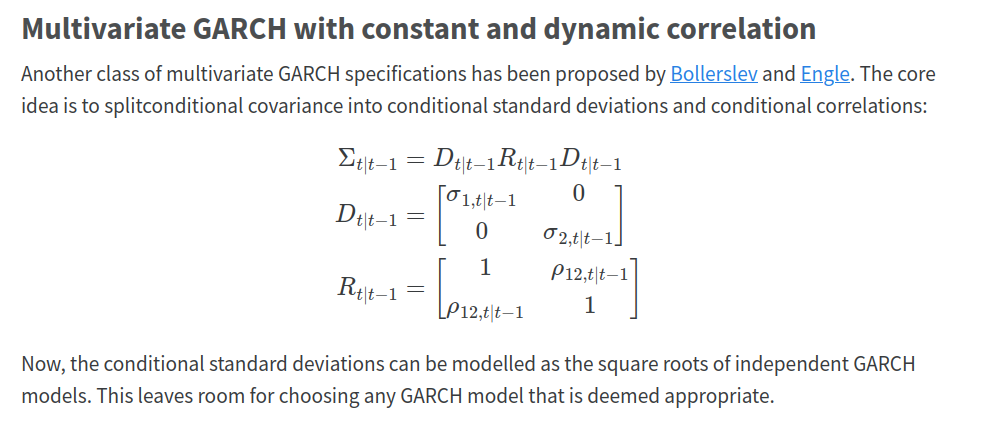

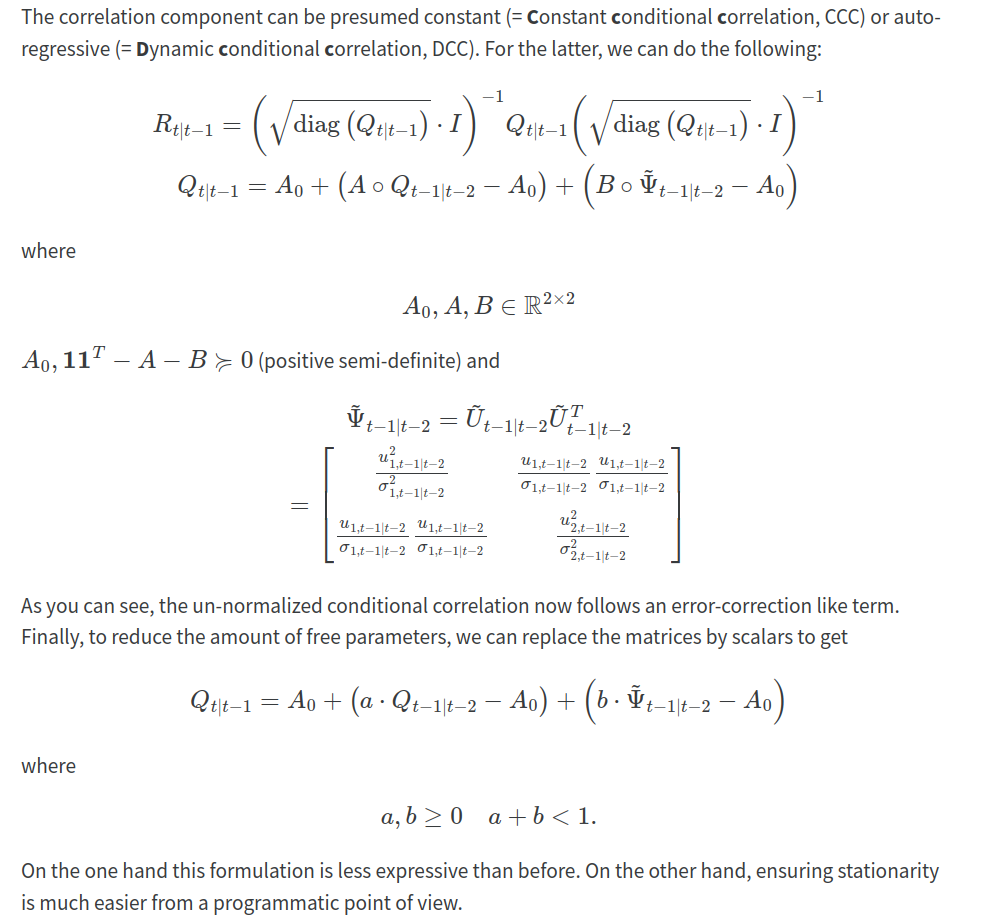

## Using Python and Tensorflow to implement DCC

Let us start with the full implementation and then look at the details:

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

class MGARCH_DCC(tf.keras.Model):
    """
    Tensorflow/Keras implementation of multivariate GARCH under dynamic conditional correlation (DCC) specification.
    Further reading:
        - Engle, Robert. "Dynamic conditional correlation: A simple class of multivariate generalized autoregressive conditional heteroskedasticity models."
        - Bollerslev, Tim. "Modeling the Coherence in Short-Run Nominal Exchange Rates: A Multi-variate Generalized ARCH Model."
        - Lütkepohl, Helmut. "New introduction to multiple time series analysis."
    """

    def __init__(self, y):
        """
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        super().__init__()
        n_dims = y.shape[1]
        self.n_dims = n_dims

        self.MU = tf.Variable(np.mean(y,0)) #use a mean variable

        self.sigma0 = tf.Variable(np.std(y,0)) #initial standard deviations at t=0

        #we initialize all restricted parameters to lie inside the desired range
        #by keeping the learning rate low, this should result in admissible results
        #for more complex models, this might not suffice
        self.alpha0 = tf.Variable(np.std(y,0))
        self.alpha = tf.Variable(tf.zeros(shape=(n_dims,))+0.25)
        self.beta = tf.Variable(tf.zeros(shape=(n_dims,))+0.25)

        self.L0 = tf.Variable(np.float32(np.linalg.cholesky(np.corrcoef(y.T)))) #decomposition of A_0
        self.A = tf.Variable(tf.zeros(shape=(1,))+0.9)
        self.B = tf.Variable(tf.zeros(shape=(1,))+0.05)


    def call(self, y):
        """
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        return self.get_conditional_dists(y)


    def get_log_probs(self, y):
        """
        Calculate log probabilities for a given matrix of time-series observations
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        return self.get_conditional_dists(y).log_prob(y)


    @tf.function
    def get_conditional_dists(self, y):
        """
        Calculate conditional distributions for given observations
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        T = tf.shape(y)[0]

        #create containers for looping
        mus = tf.TensorArray(tf.float32, size = T) #observation mean container
        Sigmas = tf.TensorArray(tf.float32, size = T) #observation covariance container


        sigmas = tf.TensorArray(tf.float32, size = T+1)
        us = tf.TensorArray(tf.float32, size = T+1)
        Qs = tf.TensorArray(tf.float32, size = T+1)


        #initialize respective values for t=0
        sigmas = sigmas.write(0, self.sigma0)
        A0 = tf.transpose(self.L0)@self.L0
        Qs = Qs.write(0, A0) #set initial unnormalized correlation equal to mean matrix
        us = us.write(0, tf.zeros(shape=(self.n_dims,))) #initial observations equal to zero


        #convenience
        sigma0 = self.sigma0
        alpha0 = self.alpha0**2 #ensure positivity
        alpha = self.alpha
        beta = self.beta

        A = self.A
        B = self.B


        for t in tf.range(T):
            #tm1 = 't minus 1'
            #suppress conditioning on past in notation

            #1) calculate conditional standard deviations
            u_tm1 = us.read(t)
            sigma_tm1 = sigmas.read(t)

            sigma_t = (alpha0 + alpha*sigma_tm1**2 + beta*u_tm1**2)**0.5

            #2) calculate conditional correlations
            u_tm1_standardized = u_tm1/sigma_tm1

            Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

            Q_tm1 = Qs.read(t)
            Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
            R_t = self.cov_to_corr(Q_t)

            #3) calculate conditional covariance
            D_t = tf.linalg.LinearOperatorDiag(sigma_t)
            Sigma_t = D_t@R_t@D_t


            #4) store values for next iteration
            sigmas = sigmas.write(t+1, sigma_t)
            us = us.write(t+1, y[t,:]-self.MU) #we want to model the zero-mean disturbances
            Qs = Qs.write(t+1, Q_t)

            mus = mus.write(t, self.MU)
            Sigmas = Sigmas.write(t, Sigma_t)

        return tfp.distributions.MultivariateNormalFullCovariance(mus.stack(), Sigmas.stack())


    def cov_to_corr(self, S):
        """
        Transforms covariance matrix to a correlation matrix via matrix operations
        Args:
            S: Symmetric, positive semidefinite covariance matrix (tf.Tensor)
        """
        D = tf.linalg.LinearOperatorDiag(1/(tf.linalg.diag_part(S)**0.5))
        return D@S@D



    def train_step(self, data):
        """
        Custom training step to handle keras model.fit given that there is no input-output structure in our model
        Args:
            S: Symmetric, positive semidefinite covariance matrix (tf.Tensor)
        """
        x,y = data
        with tf.GradientTape() as tape:
            loss = -tf.math.reduce_mean(self.get_log_probs(y))

        trainable_vars = self.trainable_weights
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"Current loss": loss}



    def sample_forecast(self, y, T_forecast = 30, n_samples=500):
        """
        Create forecast samples to use for monte-carlo simulation of quantities of interest about the forecast (e.g. mean, var, corr, etc.)
        WARNING: This is not optimized very much and can take some time to run, probably due to Python's slow loops - can likely be improved
        Args:
            y: numpy.array of training data, used to initialize the forecast values
            T_forecast: number of periods to predict (integer)
            n_samples: Number of samples to draw (integer)
        """
        T = tf.shape(y)[0]

        #create lists for looping; no gradients, thus no tf.TensorArrays needed
        #can initialize directly
        mus = []
        Sigmas = []

        us = [tf.zeros(shape=(self.n_dims,))]
        sigmas = [self.sigma0]
        Qs = []

        #initialize remaining values for t=0
        A0 = tf.transpose(self.L0)@self.L0
        Qs.append(A0)


        #convenience
        sigma0 = self.sigma0
        alpha0 = self.alpha0**2 #ensure positivity
        alpha = self.alpha
        beta = self.beta

        A = self.A
        B = self.B

        #'warmup' to initialize latest lagged features
        for t in range(T):
            #tm1 = 't minus 1'
            #suppress conditioning on past in notation
            u_tm1 = us[-1]
            sigma_tm1 = sigmas[-1]

            sigma_t = (alpha0 + alpha*sigma_tm1**2 + beta*u_tm1**2)**0.5

            u_tm1_standardized = u_tm1/sigma_tm1

            Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

            Q_tm1 = Qs[-1]
            Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
            R_t = self.cov_to_corr(Q_t)

            D_t = tf.linalg.LinearOperatorDiag(sigma_t)
            Sigma_t = D_t@R_t@D_t


            sigmas.append(sigma_t)
            us.append(y[t,:]-self.MU) #we want to model the zero-mean disturbances
            Qs.append(Q_t)

            mus.append(self.MU)
            Sigmas.append(Sigma_t)


        #sample containers
        y_samples = []
        R_samples = []
        sigma_samples = []


        for n in range(n_samples):

            mus_samp = []
            Sigmas_samp = []

            sigmas_samp = [sigmas[-1]]
            us_samp = [us[-1]]
            Qs_samp = [Qs[-1]]

            #forecast containers
            ys_samp = []
            sig_samp = []
            R_samp = []


            for t in range(T_forecast):
                u_tm1 = us_samp[-1]
                sigma_tm1 = sigmas_samp[-1]

                sigma_t = (alpha0 + alpha**2 + beta*u_tm1**2)**0.5

                u_tm1_standardized = u_tm1/sigma_tm1

                Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

                Q_tm1 = Qs_samp[-1]
                Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
                R_t = self.cov_to_corr(Q_t)

                D_t = tf.linalg.LinearOperatorDiag(sigma_t)
                Sigma_t = D_t@R_t@D_t


                sigmas_samp.append(sigma_t)
                Qs_samp.append(Q_t)

                ynext = tfp.distributions.MultivariateNormalFullCovariance(self.MU, Sigma_t).sample()
                ys_samp.append(tf.reshape(ynext,(1,1,-1)))
                sig_samp.append(tf.reshape(sigma_t,(1,1,-1)))
                R_samp.append(tf.reshape(R_t,(1,1,self.n_dims,self.n_dims)))

                us_samp.append(ynext-self.MU)

            y_samples.append(tf.concat(ys_samp,1))
            R_samples.append(tf.concat(R_samp,1))
            sigma_samples.append(tf.concat(sig_samp,1))

        return tf.concat(y_samples,0).numpy(), tf.concat(R_samples,0).numpy(), tf.concat(sigma_samples,0).numpy()

While the code is quite lengthy, its primary purpose is only twofold:

- Calculate the in-sample distribution (get_conditional_dists(…)) - is needed for optimization via maximum likelihood. This function calculates the likelihood values of each observation given the MGARCH model.
    
- Forecast the out-of sample distribution (sample_forecast(…)) - as the formulas for the model as a whole are quite complex, it’s difficult to calculate the forecast distributions in closed form. However, we can, more or less, easily sample from the target distribution. With a sufficiently large sample, we can estimate all relevant quantities of interest (e.g. forecast mean and quantiles).

Notice that here, we have specified the conditional distribution as a **multivariate Gaussian**. Given the theory from above, this is nevertheless not a necessity. A **multivariate T-distribution**, for example, could work equally well or even better. Obviously, though, a Gaussian is always nice to work with.

Now, the remaining functions are basically just helpers to maintain some structure. I decided to not break down the key functions down further in order to keep the calculations in one place. If we were unit testing our model, it would actually be sensible to split things up into better testable units.

As we want to use the Keras API for training, we need to customize the training procedure (train_step(…)). Contrary to typical Keras use-cases, our training data is not split between input and output data. Rather, we only have one set of data, namely the time-series observations.

Finally, each training step needs to process all training observations at once. (no mini-batching). Also the observations must always remain in order (no shuffling).

This yields the following generic training loop:

**model.fit(ts_data, ts_data, batch_size=len(ts_data), shuffle=False, epochs = 300, verbose=False)**

[*********************100%%**********************]  2 of 2 completed


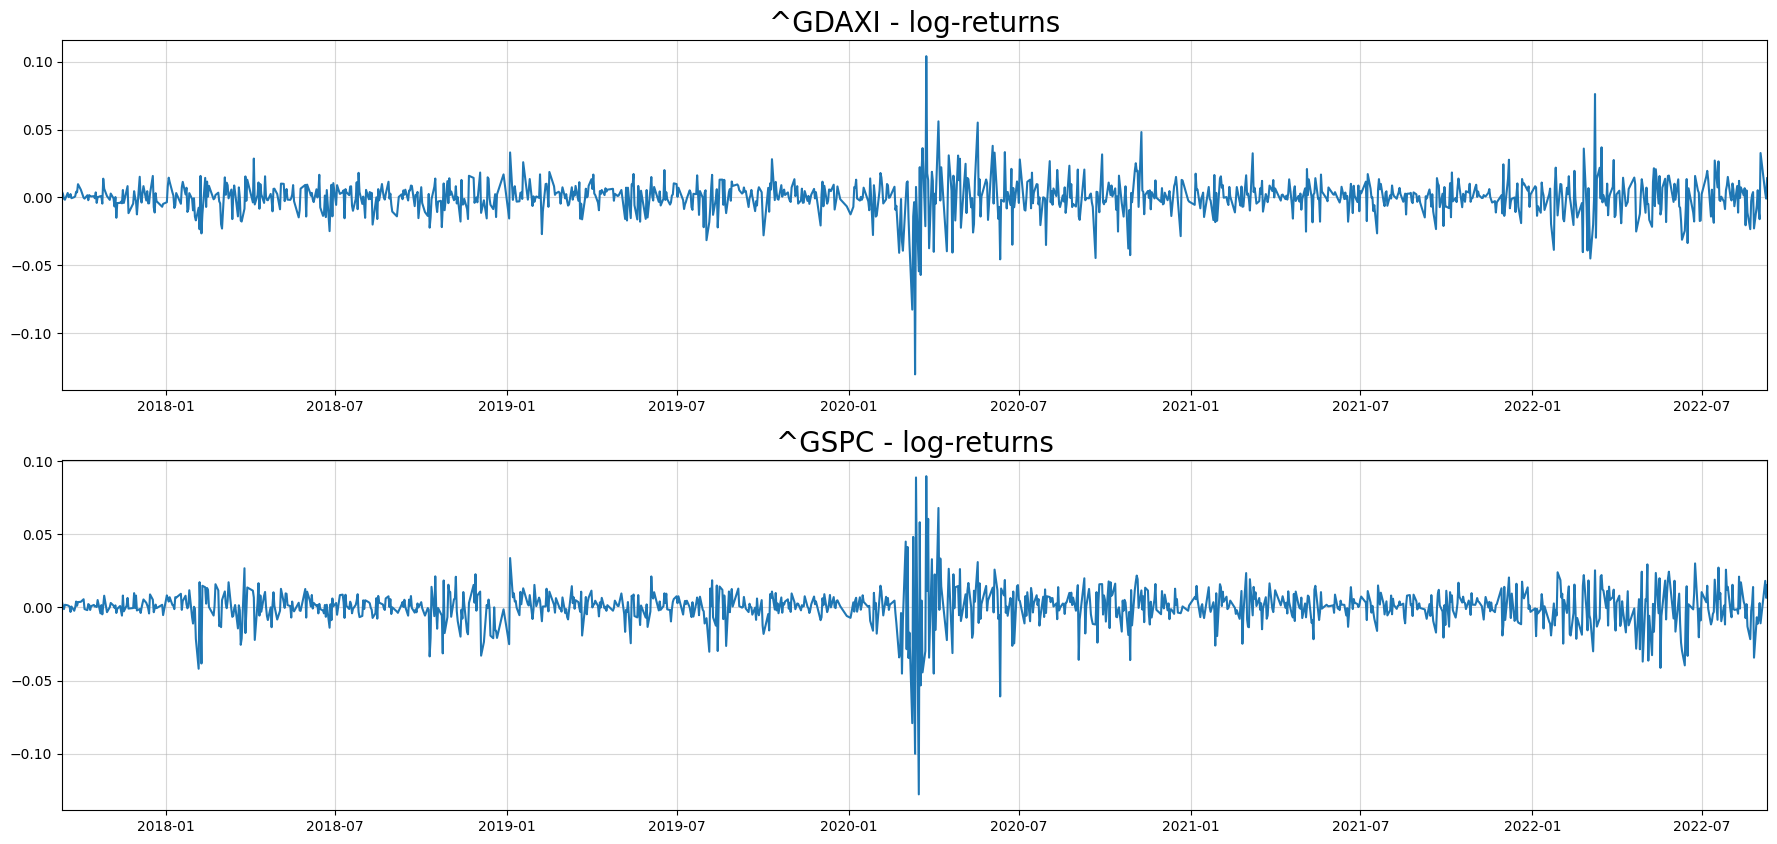

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

data = yf.download("^GDAXI ^GSPC", start="2017-09-10", end="2022-09-10", interval="1d")

close = data["Close"]
returns = np.log(close).diff().dropna()

fig, axs = plt.subplots(2,1, figsize = (22,5*2))

for i in range(2):
    axs[i].plot(returns.iloc[:,i])
    axs[i].grid(alpha=0.5)
    axs[i].margins(x=0)
    axs[i].set_title("{} - log-returns".format(returns.columns[i]),size=20)

The typical volatility clusters are visible for both time-series. To see what happens with correlation between both stocks over time, we can plot the 60-day rolling correlation:

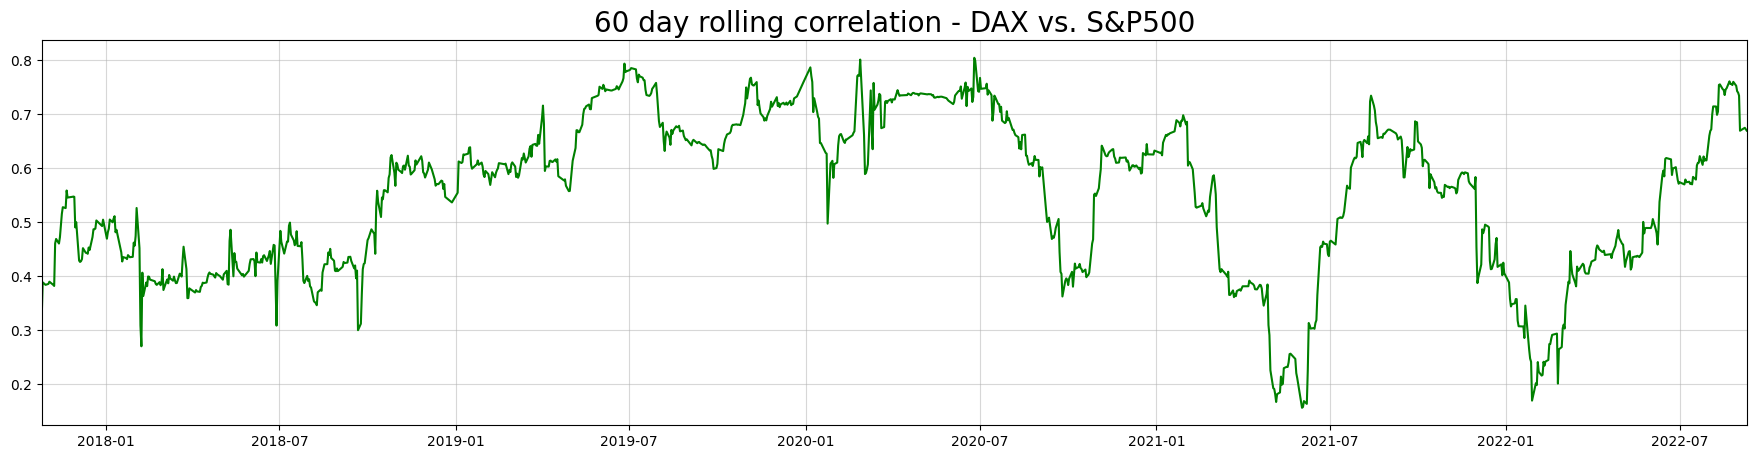

In [ ]:
import pandas as pd

rolling_corrs = returns.rolling(60,min_periods=0).corr()
gdaxi_sp500_rollcorr = rolling_corrs["^GDAXI"][rolling_corrs.index.get_level_values(1)=="^GSPC"]

plt.figure(figsize = (22,5))

plt.title("60 day rolling correlation - DAX vs. S&P500",size=20)
plt.plot(returns.index[30:],gdaxi_sp500_rollcorr.values[30:],c="green", label="60 day rolling correlation")
plt.grid(alpha=0.5)
plt.margins(x=0)

It appears as if correlation between both indices has dropped since the beginning of the pandemic. Afterwards, correlation seems to fluctuate in cycles.

All in all, the pattern looks like a discretized version of an Ornstein-Uhlenbeck process. The error correction formulation in our model should be able to capture this behaviour accordingly.

After splitting the data into train and test set (last 90 observations), we can fit the model. Then we take samples from the (90 days ahead) forecast distribution as follows (this takes some time):

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


train = np.float32(returns)[:-90,:]
test = np.float32(returns)[-90:,:]

model = MGARCH_DCC(train)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))
model.fit(train, train, batch_size=len(train), shuffle=False, epochs = 300, verbose=False)

fcast = model.sample_forecast(train,90,1000)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Now, we are particularly interested in the conditional correlation fit and forecasts:

In [ ]:
from datetime import timedelta

corrs = fcast[1][:,:,0,1]
corr_means = np.mean(corrs,0)
corr_lowers = np.quantile(corrs,0.05,0)
corr_uppers = np.quantile(corrs,0.95,0)


conditional_dists = model(np.float32(returns.values))

conditional_correlations = [model.cov_to_corr(conditional_dists.covariance()[i,:,:])[0,1].numpy() for i in range(len(returns))]

idx_train = returns[:-90].index
idx_test = pd.date_range(returns[:-90].index[-1] + timedelta(days=1), returns[:-90].index[-1] + timedelta(days=90))

fig, axs = plt.subplots(2,1,figsize=(20,12), gridspec_kw={'height_ratios': [2, 1]})

axs[0].set_title("Conditional Correlation - DAX, S&P500", size=20)

axs[0].axhline(np.corrcoef(returns.T)[0,1], c="green",alpha=0.75,ls="dashed",lw=2, label="Unconditional sample correlation")

axs[0].plot(idx_train[30:],conditional_correlations[30:-90],c="red", label="MGARCH in-sample conditional correlation")
axs[0].plot(idx_test,conditional_correlations[-90:],c="red",ls="dotted",lw=3, label="MGARCH out-of-sample conditional correlation")

axs[0].plot(idx_test, corr_means,color="blue",lw=3, alpha=0.9, label="MGARCH correlation mean forecast")
axs[0].fill_between(idx_test, corr_lowers, corr_uppers, color="blue", alpha=0.2, label="MGARCH correlation 90% forecast interval")

axs[0].grid(alpha=0.5)
axs[0].legend(prop = {"size":13})
axs[0].margins(x=0)


axs[1].set_title("Sanity check: Model predicted VS. rolling correlation",size=20)
axs[1].plot(returns.index[30:],gdaxi_sp500_rollcorr.values[30:],c="green", label="60 day rolling correlation")
axs[1].plot(returns.index[30:],conditional_correlations[30:],c="red", label="MGARCH in-sample conditional correlation")
axs[1].grid(alpha=0.5)
axs[1].legend(prop = {"size":13})
axs[1].margins(x=0)

The forecasted correlation (blue) captures the actual correlation (red) under our model quite well. Obviously though, the true correlation is unknown. Nevertheless, our model matches the rolling correlation quite well, even out-of sample. This implies that our approach is - at least - not completely off.

Being able to reliably forecast correlations might be interesting for statistical arbitrage strategies. While those strategies typically use price movements, correlations could be an interesting alternative.

From here, we could also look at price and volatility forecasts as well. To keep this article from becoming bloated, I’ll leave it to the interested reader to do this. You can find the relevant notebook here - feel free to extend with your own experiments.


## References

[1] Bollerslev, Tim. Modelling the coherence in short-run nominal exchange rates: a multivariate generalized ARCH model. The review of economics and statistics, 1990, p. 498-505.

[2] Engle, Robert. Dynamic conditional correlation: A simple class of multivariate generalized autoregressive conditional heteroskedasticity models. Journal of Business & Economic Statistics 20.3, 2002, p. 339-350.

[3] Lütkepohl, Helmut. New introduction to multiple time series analysis. Springer Science & Business Media, 2005.


## Check-Out:

https://www.sarem-seitz.com/posts/multivariate-garch-with-python-and-tensorflow.html

https://github.com/Topaceminem/DCC-GARCH/blob/master/examples/dcc_garch_modeling.ipynb

## Back-Up-Slides:



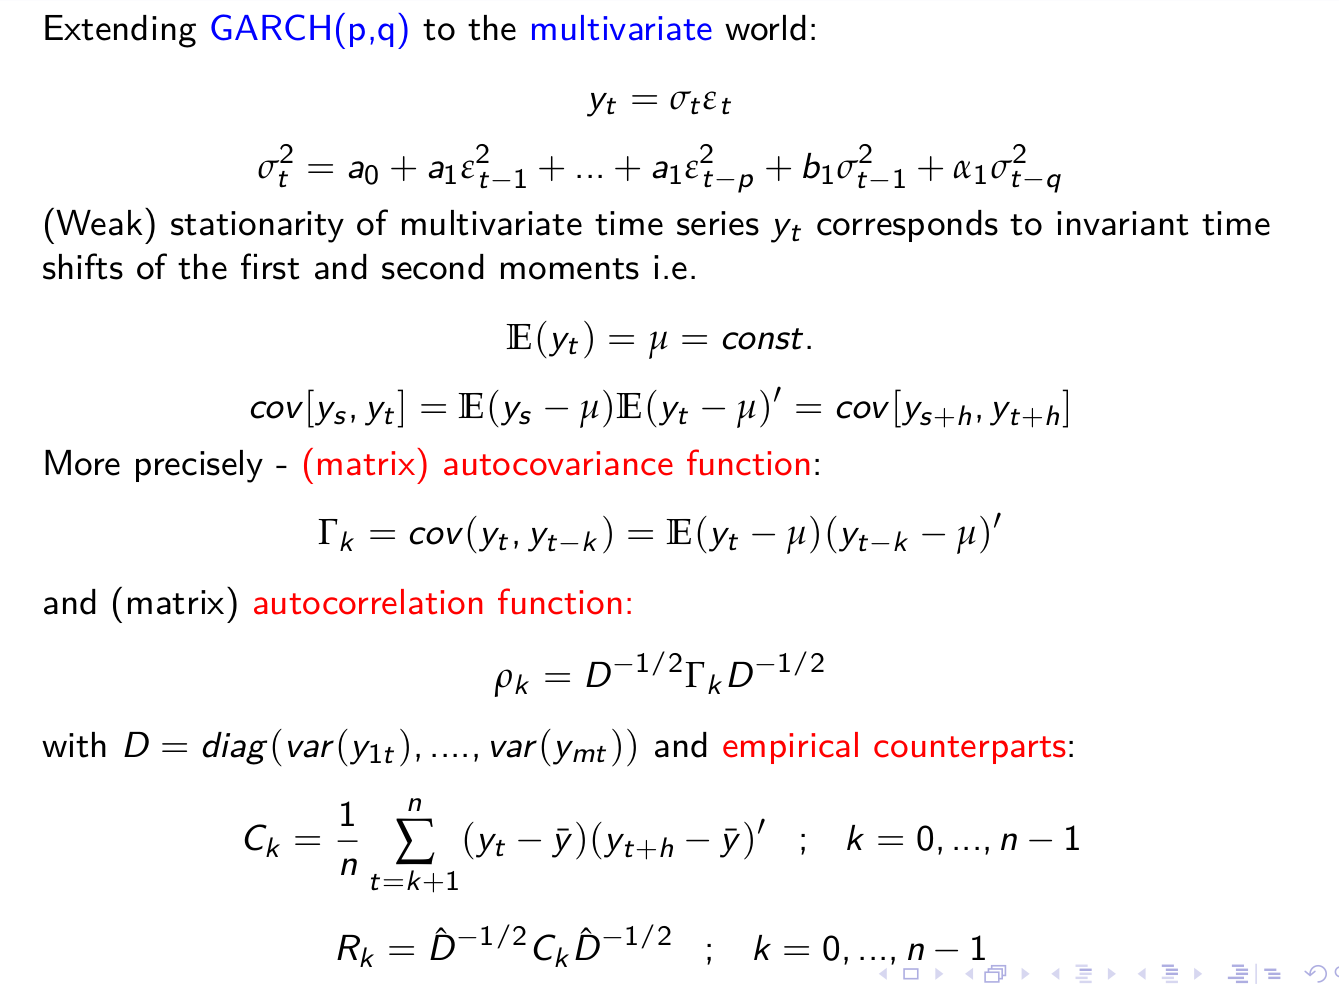

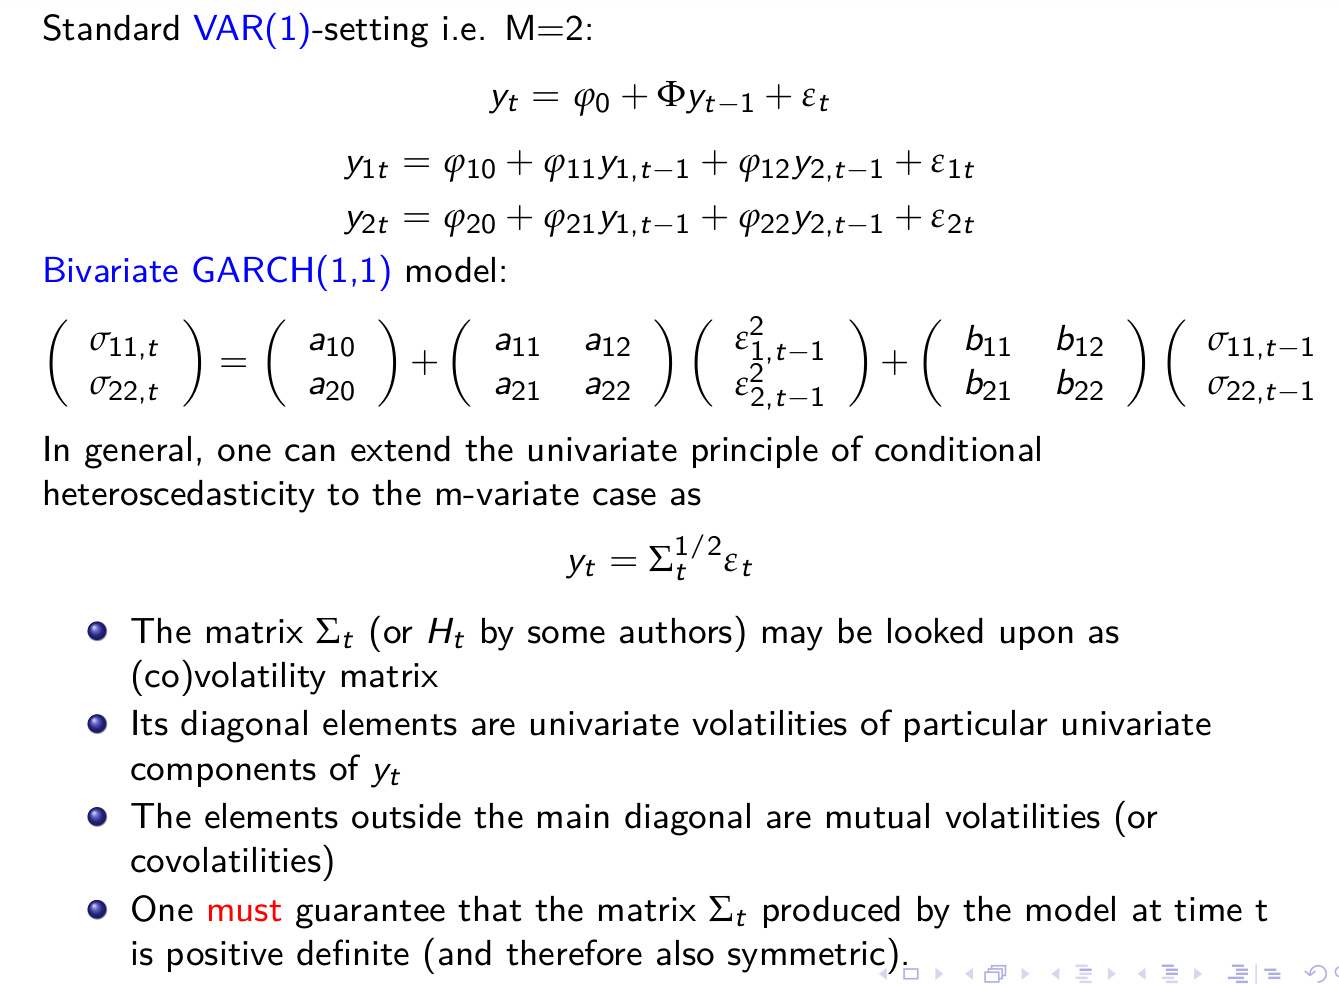

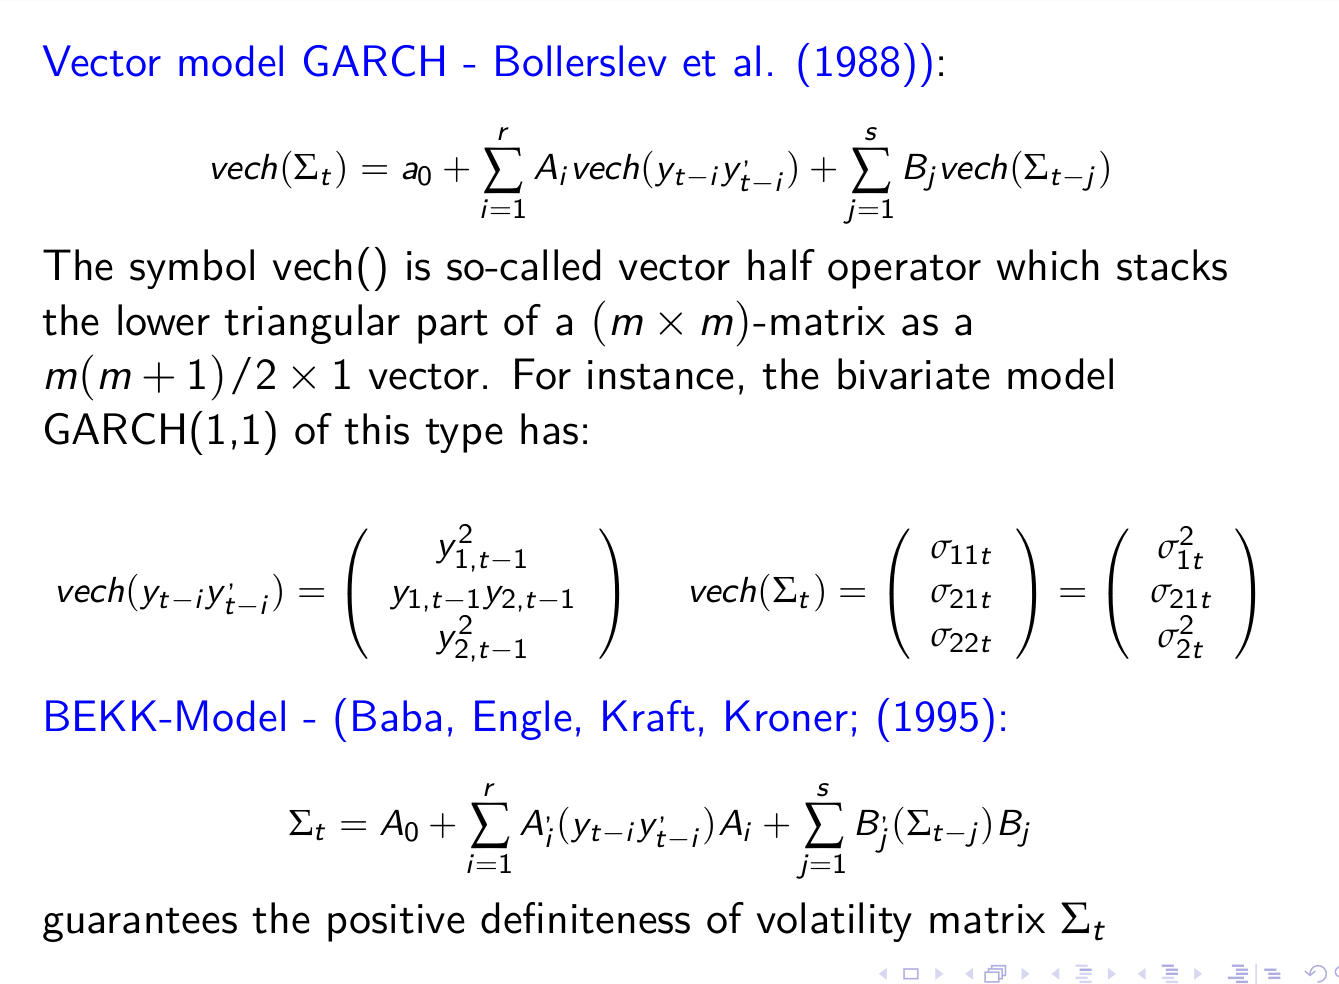

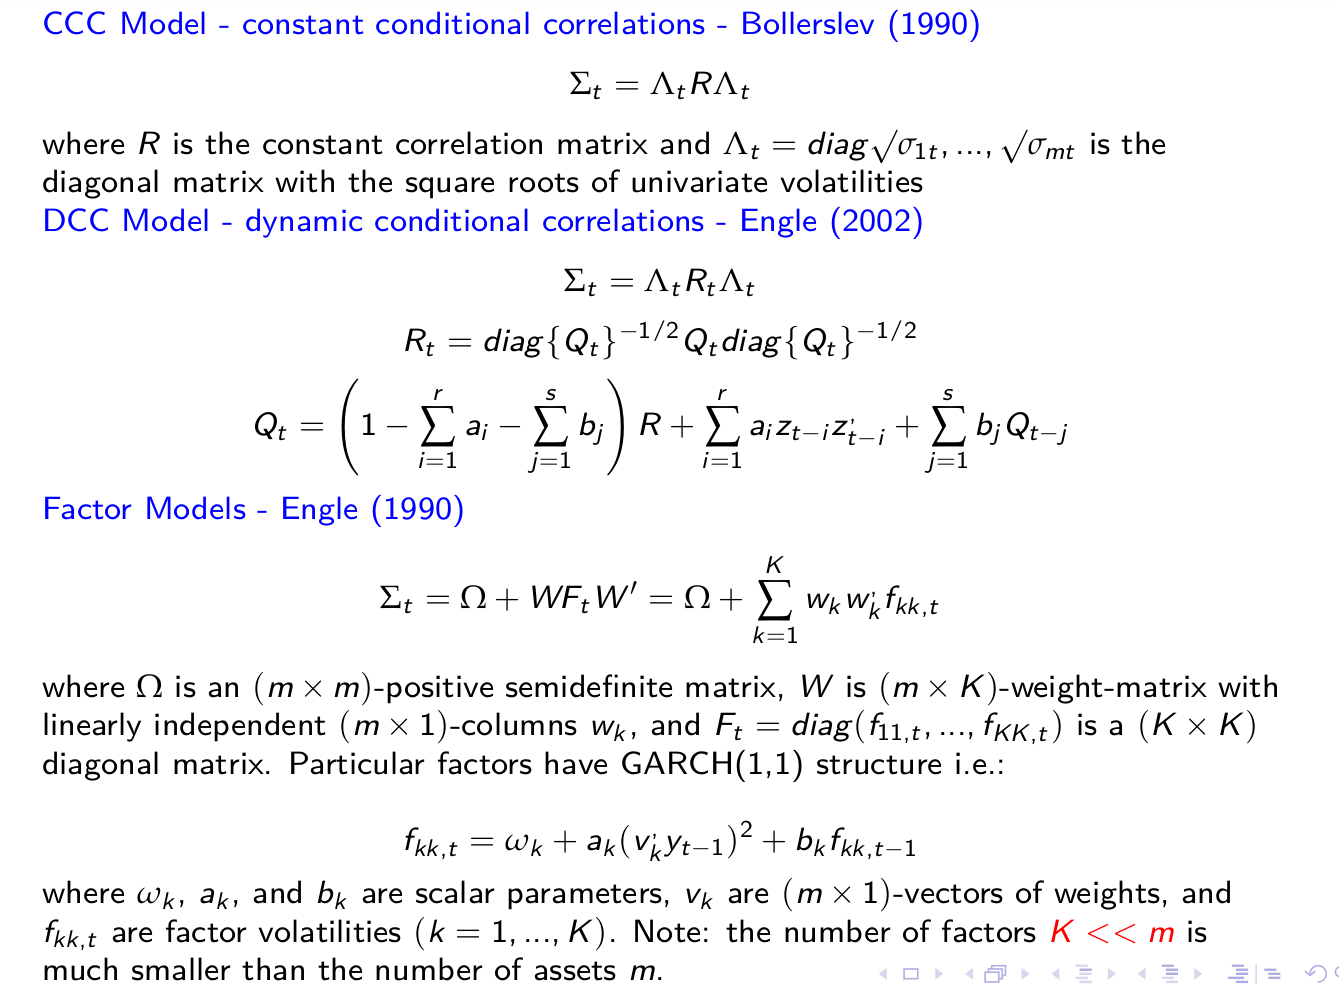

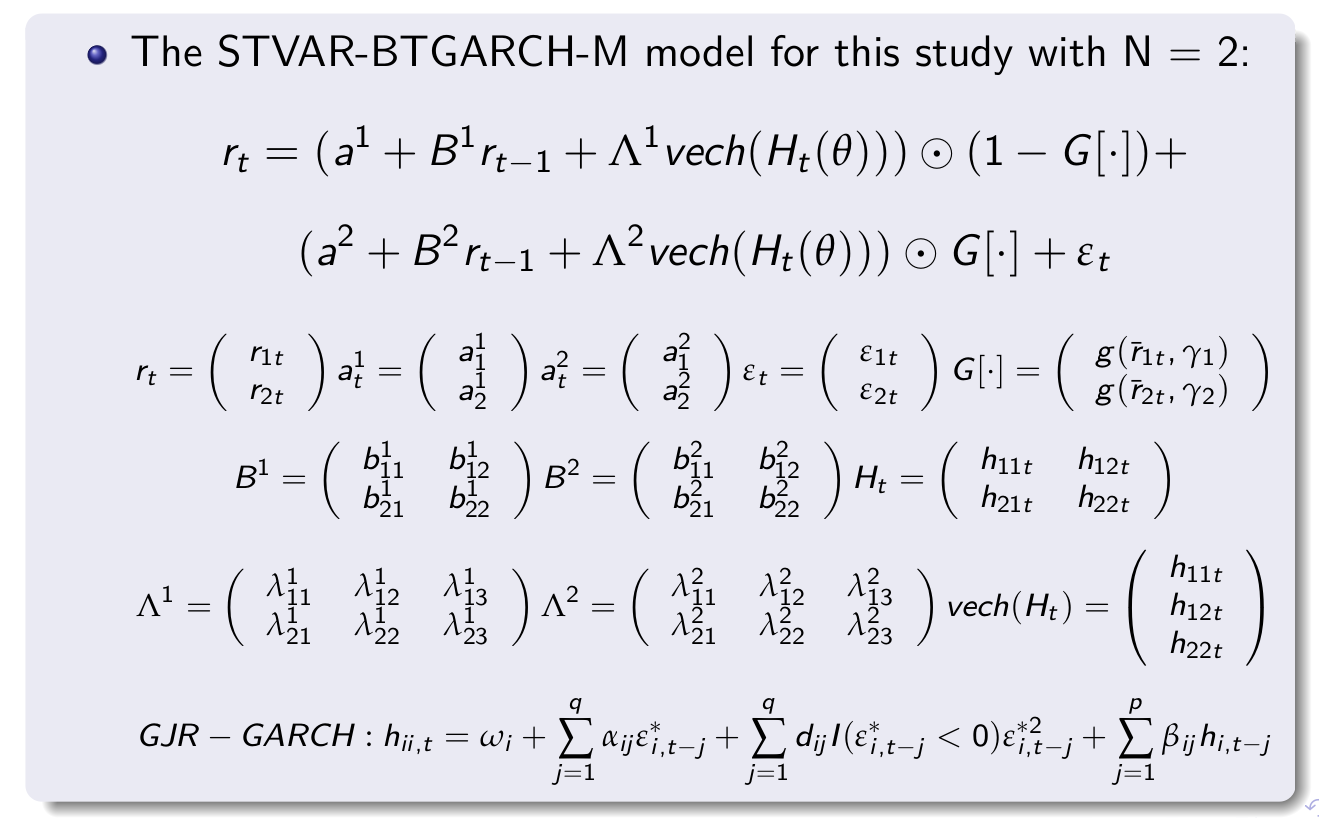